# Multiclass Classification

## Features

1. Done by Gokulakannan S
2. Multi class image classification Task
3. Model Used: VGG Model
4. Data present in Kaggle : https://www.kaggle.com/nadeemsk4347/classifying-flowers-with-keras/data . It is the same data provided to me by TMLC.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flower-dataset-102/102flowers.tgz
/kaggle/input/flower-dataset-102/imagelabels.mat


In [2]:
#Importing the necessary Libraries
import os
import numpy as np
import scipy.io
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
import tarfile
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import Sequential
from tensorflow.keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout


## Step 1 : Processing Labels

In [3]:
img_labels = scipy.io.loadmat("/kaggle/input/flower-dataset-102/imagelabels.mat")
img_labels = img_labels["labels"]
img_labels = img_labels[0]
for i in range(len(img_labels)):
  img_labels[i] = img_labels[i] - 1
print(img_labels)

[76 76 76 ... 61 61 61]


## Step 2 : Processing Images

In [4]:
# We are reducing the dimensions of the images to 50 X 50
IMG_SIZE = 50

train_x = []
train_y = []
tar = tarfile.open('/kaggle/input/flower-dataset-102/102flowers.tgz', "r:gz")
i = 0
for tarinfo in tqdm(tar):
    i+=1
    tar.extract(tarinfo.name)
    
    if(tarinfo.name[-4:] == '.jpg'):
        var = tarinfo.name[11:15]
        img_num = int(var)-1
        train_y.append(img_labels[img_num])
        
        image = cv2.imread(tarinfo.name) #reading the image
        resized = cv2.resize(image, (IMG_SIZE,IMG_SIZE)) # changing image size to 50 X 50
        normalized_img = cv2.normalize(resized, None, alpha=0, beta=1, 
                                norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #normalizing the pixels
        train_x.append(normalized_img)

#         label_list.append(tarinfo.name.split('_')[0])
    if(tarinfo.isdir()):
        os.rmdir(tarinfo.name)
    else:
        os.remove(tarinfo.name) 

tar.close()
train_x = np.array(train_x) # creating the training data

8190it [00:46, 175.77it/s]


Image shape (8189, 50, 50, 3)
The Label of this image is  73


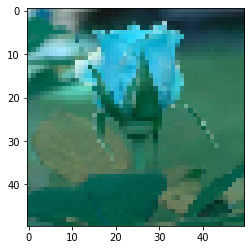

In [5]:
#Change the number in from 0 to 8189 to look into any image
plt.imshow(train_x[8180])
print("Image shape",train_x.shape)
print("The Label of this image is ",train_y[8180])

## Step 3 : Data Validation (Train, Validation and Test split)

In [6]:
#training and test are split here
trainx, testx, trainy, testy = train_test_split(train_x, train_y, test_size=0.10, random_state=10)

trainx, valx, trainy, valy = train_test_split(trainx, trainy, test_size=0.15, random_state=10)

trainy = to_categorical(trainy)#categorizing the labels by converting the class labels to a binary class matrix
testy = to_categorical(testy)
valy = to_categorical(valy)
np.save('testx.npy', testx)
np.save('testy.npy', testy)

print("Training data number:",len(trainx))
print("Testing data number:",len(testx))
print("Validation data number:",len(valx))

print("Training labels number:",len(trainy))
print("Testing labels number:",len(testy))
print("Validation labels number:",len(valy))

Training data number: 6264
Testing data number: 819
Validation data number: 1106
Training labels number: 6264
Testing labels number: 819
Validation labels number: 1106


## Step 4 : Model Building

In [7]:
# model 1
# The model is creating taking the base model as VGG19
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (50,50,3), classes = trainy.shape[1])

2021-10-26 13:00:30.806295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 13:00:30.900106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 13:00:30.900833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 13:00:30.901972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


![VGG Network](https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)!

In [8]:
#Creating extra deep neural layers for transfer learning
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(102,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [11]:
#learning rate parameter to initialize the learning rate to the model
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [12]:
#Initializing the hyperparameters
batch_size= 100
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
#fitting the first model
model.fit(trainx, trainy, validation_data = (valx, valy), epochs=60, batch_size=20)

2021-10-26 13:00:37.727261: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2021-10-26 13:00:39.422889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


314/314 [==============================] - 17s 31ms/step - loss: 4.4157 - accuracy: 0.0508 - val_loss: 3.7842 - val_accuracy: 0.1410
Epoch 2/60
314/314 [==============================] - 9s 29ms/step - loss: 3.5355 - accuracy: 0.1828 - val_loss: 3.2256 - val_accuracy: 0.2396
Epoch 3/60
314/314 [==============================] - 9s 29ms/step - loss: 2.7974 - accuracy: 0.2992 - val_loss: 2.6665 - val_accuracy: 0.3137
Epoch 4/60
314/314 [==============================] - 9s 29ms/step - loss: 2.2681 - accuracy: 0.4112 - val_loss: 1.9600 - val_accuracy: 0.4720
Epoch 5/60
314/314 [==============================] - 9s 29ms/step - loss: 1.8719 - accuracy: 0.4960 - val_loss: 1.7604 - val_accuracy: 0.5325
Epoch 6/60
314/314 [==============================] - 9s 29ms/step - loss: 1.5816 - accuracy: 0.5663 - val_loss: 1.7565 - val_accuracy: 0.5570
Epoch 7/60
314/314 [==============================] - 9s 29ms/step - loss: 1.3655 - accuracy: 0.6218 - val_loss: 1.4347 - val_accuracy: 0.6184
Epoch 8/6

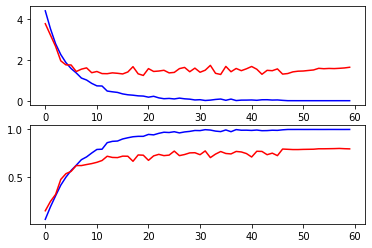

In [14]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [15]:
model.save('vgg_transfer_learning_102_model.h5')

### Here we get the training accuracy to be 99% but the validation accuracy is 79%(maximum).

## Step 5 : Testing the model

In [16]:
# Model 1 Testing
from keras.models import load_model
model = load_model("vgg_transfer_learning_102_model.h5")

score = model.evaluate(testx, testy)

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

#Predict output on sample input data
pred = model.predict(testx) 
pred = np.argmax(pred, axis = 1)[:10] 
label = np.argmax(testy,axis = 1)[:10] 

print("Predicted labels:",pred) 
print("Actual Labels:   ",label)

26/26 [==============================] - 1s 19ms/step - loss: 2.0056 - accuracy: 0.7607
Test loss: 2.0056068897247314
Test accuracy: 0.7606837749481201
Predicted labels: [50 57 34 37  7 64 77 75 16 50]
Actual Labels:    [50 57 34 37  7 64 77 75 16 50]


# Conclusion

### Hence the model seems to perform well with an accuracy of 74.23%. Further accuracy can be increased by introducing better architectures like MobileNet or ResNet or by using data augmentation technique.

# Refrences

1. https://analyticsindiamag.com/transfer-learning-for-multi-class-image-classification-using-deep-convolutional-neural-network/
2. https://www.kaggle.com/nadeemsk4347/classifying-flowers-with-keras


